# BEAT challenge

In [85]:
import pandas as pd
import numpy as np
import pickle

## Load Pickled requests.csv

In [4]:
with open('request.pickle', 'rb') as handle:
    df_req = pickle.load(handle)
#df_req = df_req.sample(n=5000)


## Convert columns to datetime

In [5]:
df_req['created_at'] = pd.to_datetime(df_req['created_at'])
df_req['cancelled_at'] = pd.to_datetime(df_req['cancelled_at'])

In [6]:
df_req.head()

,id_request,id_passenger,id_city,from_latitude,from_longitude,to_latitude,to_longitude,created_at,cancelled_at,timedout_at,passenger_device,passenger_payment_mean,passenger_udid,distance_estimate,duration_estimate
0,3513924914,2590587260,1,19.593987,-99.039326,19.578557,-99.041541,2019-09-19 04:07:56,2019-09-19 04:08:01,NaN,PIXI5-6_4G/9008A,cash,2026460688,3.47,NaN
1,1594446343,1501665959,1,19.303307,-98.886432,19.261320,-98.878055,2019-09-19 22:44:43,NaT,NaN,tissot_sprout/Mi A1,cash,4196047656,6.81,512.0
2,2312709661,1546836297,1,19.326330,-99.121689,19.310036,-99.124487,2019-09-19 23:00:37,NaT,NaN,deen_sprout/motorola one,cash,166030629,2.19,788.0
3,1498373688,2884063389,1,19.401755,-99.175365,19.400671,-99.188342,2019-09-20 16:31:24,NaT,NaN,HWNXT/HUAWEI NXT-L09,cash,510294940,2.93,750.0
4,197696634,2893722658,1,19.392388,-99.057337,19.370834,-99.005069,2019-09-20 23:26:56,2019-09-20 23:29:31,NaN,dream2lte/SM-G955F,cash,3552408027,9.53,NaN


## One-hot encode payment method

In [7]:

df_req = pd.get_dummies(df_req, columns=['passenger_payment_mean'])


In [9]:
df_req.head()

,id_request,id_passenger,id_city,from_latitude,from_longitude,to_latitude,to_longitude,created_at,cancelled_at,timedout_at,passenger_device,passenger_udid,distance_estimate,duration_estimate,passenger_payment_mean_cash,passenger_payment_mean_cc
0,3513924914,2590587260,1,19.593987,-99.039326,19.578557,-99.041541,2019-09-19 04:07:56,2019-09-19 04:08:01,NaN,PIXI5-6_4G/9008A,2026460688,3.47,NaN,1,0
1,1594446343,1501665959,1,19.303307,-98.886432,19.261320,-98.878055,2019-09-19 22:44:43,NaT,NaN,tissot_sprout/Mi A1,4196047656,6.81,512.0,1,0
2,2312709661,1546836297,1,19.326330,-99.121689,19.310036,-99.124487,2019-09-19 23:00:37,NaT,NaN,deen_sprout/motorola one,166030629,2.19,788.0,1,0
3,1498373688,2884063389,1,19.401755,-99.175365,19.400671,-99.188342,2019-09-20 16:31:24,NaT,NaN,HWNXT/HUAWEI NXT-L09,510294940,2.93,750.0,1,0
4,197696634,2893722658,1,19.392388,-99.057337,19.370834,-99.005069,2019-09-20 23:26:56,2019-09-20 23:29:31,NaN,dream2lte/SM-G955F,3552408027,9.53,NaN,1,0


## Create was_canceled column

This column will be 1 if the request was canceled

In [10]:
df_req['was_canceled'] = df_req['cancelled_at'].isnull()
df_req['row'] = 1 #this is a helper column

## Created time_to_cancel column
As the difference from created_at and cancelled_at. Nulls were filled with -999 just to be able to use plotting tools

In [12]:
df_req['time_to_cancel']= df_req['cancelled_at'] - df_req['created_at']
df_req['time_to_cancel'] = df_req['time_to_cancel'].fillna(pd.Timedelta(seconds=0))
df_req['time_to_cancel'].describe()

count                     10425144
mean     0 days 00:00:23.326642106
std      0 days 00:16:19.898338541
min                0 days 00:00:00
25%                0 days 00:00:00
50%                0 days 00:00:00
75%                0 days 00:00:05
max               33 days 00:12:42
Name: time_to_cancel, dtype: object

## Histogram 

We could see a peak from 1 to 5 seconds. This is in line with the challange instructions

<AxesSubplot:xlabel='time_to_cancel'>

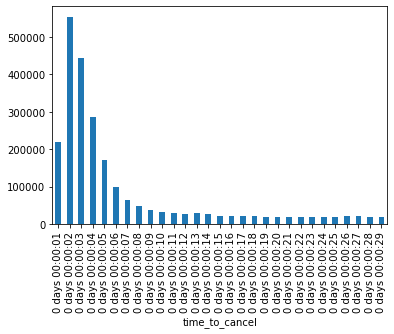

In [15]:
import matplotlib.pyplot as plt



mask = (df_req["time_to_cancel"] > pd.Timedelta(seconds=0)) & (df_req["time_to_cancel"] < pd.Timedelta(seconds=30))
df = df_req[mask]

df.set_index('time_to_cancel', inplace=True)
df.resample('1S').size().plot.bar()


### Now we will see what if we filter CC requests only

<AxesSubplot:xlabel='time_to_cancel'>

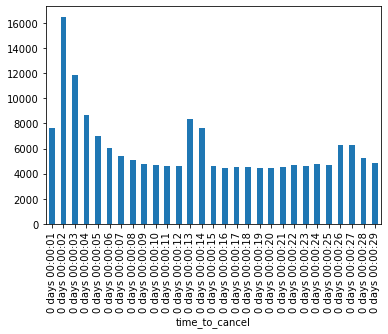

In [19]:
df[df['passenger_payment_mean_cc']==1].resample('1S').size().plot.bar()

There is a spike on 2 and 3 seconds, but compared to the average, this delta is small. 

In [ ]:
#df_req['count_canceled_by_user'] = df_req.groupby('id_passenger')['was_canceled'].transform(np.sum)
#df_req['count_request_by_user'] = df_req.groupby('id_passenger')['row'].transform(np.sum)

## Group by user and drop some columns

In [21]:
df_req_gp = df_req.groupby('id_passenger').sum()
df_req_gp = df_req_gp.drop(columns=['from_latitude', 'from_longitude','to_latitude','to_longitude'])

### Create a cancel_rate column

In [23]:
df_req_gp = df_req_gp[df_req_gp['was_canceled'].notnull()]
df_req_gp['cancel_rate']=df_req_gp['was_canceled']/df_req_gp['row']
df_req_gp.head()

,id_request,id_city,passenger_udid,distance_estimate,duration_estimate,passenger_payment_mean_cash,passenger_payment_mean_cc,was_canceled,row,cancel_rate
id_passenger,,,,,,,,,,
4421,4009186975,1,211686013,1.97,298.0,0.0,1.0,1,1,1.000000
17500,16735817555,9,708257610,73.87,2690.0,9.0,0.0,6,9,0.666667
21566,25916832734,14,39344800208,64.74,1558.0,14.0,0.0,8,14,0.571429
26581,5567630726,9,4296822432,15.90,2439.0,3.0,0.0,3,3,1.000000
34374,323163638,1,1607201580,3.43,0.0,1.0,0.0,0,1,0.000000


## Plot cancel_rate with some dimensions

### Plot for all users

In [28]:
mask = df_req_gp['passenger_payment_mean_cc']>0
cc = df_req_gp[mask]

mask3 = df_req_gp['passenger_payment_mean_cash']>0
cashs = df_req_gp[mask3]
mask4 = cashs['passenger_payment_mean_cc'] == 0
cash = cashs[mask4]

<AxesSubplot:xlabel='cancel_rate'>

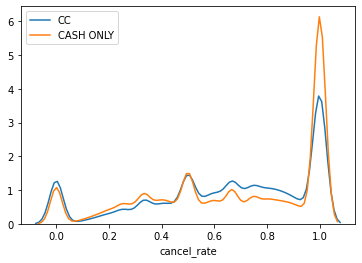

In [29]:
import seaborn as sns
sns.distplot(cc["cancel_rate"], bins = 20,hist = False,label = 'CC')
sns.distplot(cash["cancel_rate"], bins = 20,hist = False ,label = 'CASH ONLY')




### Plot for more than 4 usages

<AxesSubplot:xlabel='cancel_rate'>

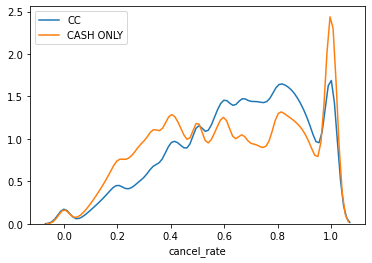

In [33]:
mask = df_req_gp['passenger_payment_mean_cc']>4
cc = df_req_gp[mask]

mask3 = df_req_gp['passenger_payment_mean_cash']>4
cashs = df_req_gp[mask3]
mask4 = cashs['passenger_payment_mean_cc'] == 0
cash = cashs[mask4]
sns.distplot(cc["cancel_rate"], bins = 20,hist = False,label = 'CC')
sns.distplot(cash["cancel_rate"], bins = 20,hist = False ,label = 'CASH ONLY')

### Plor for more than 20 usages

<AxesSubplot:xlabel='cancel_rate'>

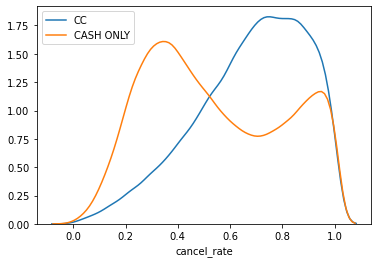

In [46]:
mask = df_req_gp['passenger_payment_mean_cc']>20
cc = df_req_gp[mask]

mask3 = df_req_gp['passenger_payment_mean_cash']>20
cashs = df_req_gp[mask3]
mask4 = cashs['passenger_payment_mean_cc'] == 0
cash = cashs[mask4]
sns.distplot(cc["cancel_rate"], bins = 20,hist = False,label = 'CC')
sns.distplot(cash["cancel_rate"], bins = 20,hist = False ,label = 'CASH ONLY')

As we can see there is a significan amount of users with cancelation_rate = 1, even in more than 20 usages.
It's clear that this suspucious spike is smaller for frequent users and it decreeses faster for credit card users.

In the last plot, it seems that the cash only group is the sum of two totally diffent distributions, maybe fraudsters and legit users.

This two different groups is not so evident on credit card group, but in lower usage there is a suspicious amount of cancel_rate = 1 on four uses. We could not asume that credit card users are totally legit, but we could be less severe.

## How to setup a threeshold

First we will filter users with a cancel_rate equals 1 and analyze how many requests had they made

In [71]:
mask = df_req_gp['cancel_rate']== 1
fil = df_req_gp[mask]
fil['row'].describe()

count    256751.000000
mean          3.692753
std           5.566465
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max         225.000000
Name: row, dtype: float64

We could see that 256k users from 750k, had no non-canceled requests. Most of them made no more than 4 requests, but in some cases they made more than 200.

Based on this, we should get a threeshold number of requests from when we decide that a user is making a fraudulent request. 
Ideally we should have ground truth values, but as is not provided, I found that 10 gives us around a 2% of fraud and is a reasonable number for a user to 'learn' how to use the service

In [84]:
mask = df_req_gp['cancel_rate']== 1
fil2 = df_req_gp[mask]
mask2 = fil2['row'] > 10
fil = fil2[mask2]
fil['row'].describe()

count    16719.000000
mean        19.381004
std         12.163098
min         11.000000
25%         12.000000
50%         15.000000
75%         21.000000
max        225.000000
Name: row, dtype: float64

### Threeshold conclusions

* We will label all users with more than 10 requests and a cancelation_rate of 1, as fraudsters

* Please note that users with more than 10 and some requests accepted, will not be labeled, for example if some user one the 15th attempt, actually pays the trip, is not a fraudster

* Payment method will not be used to select fraudsters, but will be a feature to predict among users

## Next steps for the next notebook

1) Select a way to split the dataset in order to test the model results

2) Select a way to measure the accuracy of the predictions

3) Build the corresponding features and train a model


